# Реализация решающего дерева 

In [2]:
import numpy as np
import numpy.testing as npt

from sklearn.metrics import accuracy_score

Решающее дерево - алгоритм машинного обучения, задающийся специальным графом-деревом. В данном ноутбуке реализовано бинарное дерево. Каждая внутренняя вершина такого дерева соответствует функции-предикату $\mathbb{I}[x_{\alpha} \geq \beta]$. Каждая листовая вершина соответствует некоторому значению ответа, которое будет выдавать алгоритм (вещественное число в случае регрессии, номер класса или вектор вероятностей в случае классификации).

На этапе обучения необходимо построить само дерево, а также выбрать $\alpha$ и $\beta$ для каждой внутренней вершины и метку прогноза для каждой листовой вершины. 
Изначально для каждого объекта вычисляется значение функции-предиката корневой вершины. Если оно равно нулю, то алгоритм переходит в левую дочернюю вершину, иначе в правую. Затем вычисляется значение предиката в новой вершине и делается переход или влево, или вправо. Процесс продолжается, пока не будет достигнута листовая вершина. Алгоритм возвращает то значение, которое будет приписано этой вершине.

### Выбор $\alpha$ и $\beta$

На этапе построения дерева выбираются предикаты для каждой новой вершины, максимизируя функционал качества для разбиения вершины на два поддерева, который можно записать в следующем виде:
$$ Q(R, \alpha, \beta) = H(R) - \frac{|R_l|}{|R|} H(R_l) - \frac{|R_r|}{|R|} H(R_r) $$

* $H$ - критерий информативности
* $R$ - объекты в текущей вершине
* $R_r$ - объекты, попадающие в правое поддерево
* $R_l$ - объекты, попадающие в левое поддерево

Например, критерий информативности Джини для задачи классификации задаётся следующей оптимизационной задачей:


$$H(R) = \min_{c: \; \sum_{k=1}^K c_k = 1} \frac{1}{|R|} \sum_{(x_i, y_i) \in R} \sum_{k=1}^K (c_k - \mathbb{I}[y_i=k])^2$$

Решение задачи можно найти аналитически:
$$H(R) = \sum_{k=1}^K p_k (1 - p_k)$$

* $p_k$ - доля объектов с классом $k$ среди $R$
* $K$ - общее число классов

При разбиении вершины на два поддерева нужно максимизировать функционал качества и оптимизировать:

* $\alpha$ - номер признака в предикате
* $\beta$ - пороговое значение предиката

В данном ноутбуке оптимизация проводится при полном переборе значений. Для $\alpha$ множество перебираемых значений - все имеющиеся признаки, для $\beta$ - все встречающиеся в обучающей выборке значения каждого признака, кроме наименьшего.

## 1. Вычисление значения в листе дерева 

Начнем построение дерева с реализации функции выдачи ответов в листе дерева. В качестве такой функции будет использована доля объектов каждого класса среди объектов обучающей выборки, попавших в лист.

Ниже реализован метод класса `ClassificationProbabilityMatcher`, вычисляющий по поданному массиву ответов, долю каждого из классов по этому массиву. Предполагается, что массив $y$ состоит из целых чисел от $0$ до $K-1$, где $K$ - количество классов.

In [3]:
class BasePredictionMatcher:
    def get_prediction_value(self, y):
        raise NotImplementedError

class ClassificationProbabilityMatcher(BasePredictionMatcher):
    def __init__(self, n_classes=None):
        self.n_classes = n_classes
    
    def get_prediction_value(self, y):

        counts = np.bincount(y, minlength=self.n_classes)
        return counts / len(y)

Проверка

In [4]:
some_y = np.array([1, 1, 2, 4, 2, 2, 0, 1, 0, 4])
probability_matcher = ClassificationProbabilityMatcher(n_classes=6)
assert probability_matcher.get_prediction_value(some_y).tolist() == [0.2, 0.3, 0.3, 0, 0.2, 0]

In [5]:
probability_matcher.get_prediction_value(some_y)

array([0.2, 0.3, 0.3, 0. , 0.2, 0. ])

## 2. Вычисление параметров предиката

Ниже реализовано несколько методов. Для класса `BaseInformationCriterion` - методы:
* `find_best_split` - вычисление оптимального $\beta$ и $Q$ при фиксированном признаке $\alpha$ и при векторе ответов $y$
* `get_Q` - вычисление функционала $Q$

Для класса `GeanyInformationCriterion` - метод `get_H`, вычисляющий значение критерия информативности. 

In [6]:
class BaseInformationCriterion:
    def find_best_split(self, X_feature, y):
        
        best_Q = -float("inf")
        best_threshold = None
        
        H_main = self.get_H(y)
        possible_thresholds = sorted(list(set(X_feature)))[1:]
        for threshold in possible_thresholds:
            right_objects_mask = X_feature >= threshold
            right_y = y[right_objects_mask]
            left_y = y[~right_objects_mask]
            Q_value = self.get_Q(H_main, left_y, right_y)
            
            if Q_value > best_Q:
                best_Q = Q_value
                best_threshold = threshold
        return best_threshold, best_Q
        
    def get_Q(self, H_main, y_left, y_right):

        total_lenght = len(y_left) + len(y_right)
        Q = ( 
             H_main - len(y_left) / total_lenght * self.get_H(y_left) -
             len(y_right) / total_lenght * self.get_H(y_right)
            )
        return Q
    
    def get_H(self, y):
        raise NotImplementedError

In [7]:
class GeanyInformationCriterion(BaseInformationCriterion):
    def __init__(self, n_classes=None):
        self.probability_matcher = ClassificationProbabilityMatcher(n_classes=n_classes)
        
    def get_H(self, y):
        
        probabilities = self.probability_matcher.get_prediction_value(y)
        return sum(probabilities * (1 - probabilities))

Проверка

In [8]:
geany_criterion = GeanyInformationCriterion(n_classes=5)
main_H = geany_criterion.get_H(some_y)
npt.assert_almost_equal(main_H, 0.74, 4)

In [9]:
npt.assert_almost_equal(
    geany_criterion.get_Q(main_H, [1, 1, 1, 0], [2, 2, 0, 2, 4, 4]),
    0.22333333333333327,
    decimal=4
)

In [10]:
some_X_feature = np.array([-5, -4, 1, 2, 3, 2, -3, -1, -2, 2])

best_threshold, best_Q = geany_criterion.find_best_split(some_X_feature, some_y)
assert best_threshold == 1
npt.assert_almost_equal(best_Q, 0.26, 4)

## 3. Реализация вершины дерева

Класс `TreeNode` задаёт одну вершину дерева (листовую или внутреннюю). У каждого объекта класса есть следующие атрибуты:

* feature_index - индекс признака ($\alpha$), по которому строится предикат
* threshold - пороговое значение ($\beta$), по которому строится предикат
* prediction_value - значение, которое будет выдавать алгоритм для объектов, попавших в эту вершину, если она является листовой
* right_children - ссылка на правую вершину-ребёнка
* left_children - ссылка на левую веришну-ребёнка

Реализованы два метода класса:
* метод `get_next_nodes_mask` - получает значения предиката для попадающих в вершину объектов;
* метод `split_node` - превращает вершину из листовой во внутреннуюю: вычисляет значения параметров `feature_index` и `threshold` и создаёт две дочерних вершины, присваивая им нужные `prediction_value`.

In [11]:
class TreeNode:
    def __init__(self, prediction_value, feature_index=None, threshold=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.prediction_value = prediction_value
        self.right_children = None
        self.left_children = None
        
    @property
    def is_terminal(self):
        if self.right_children is None and self.left_children is None:
            return True
        return False
    
    def get_next_nodes_mask(self, X):
        
        X_feature = X[:, self.feature_index].ravel()
        mask = X_feature >= self.threshold
        return mask 
        
    def split_node(self, X, y, criterion, prediction_matcher):

        best_Q = -float("inf")
        for alpha in range(X.shape[1]):
            threshold, Q_value = criterion.find_best_split(X[:, alpha], y)
            if Q_value > best_Q:
                best_Q = Q_value
                self.threshold = threshold
                self.feature_index = alpha
        mask = self.get_next_nodes_mask(X)
        self.right_children = TreeNode(prediction_matcher.get_prediction_value(y[mask]))
        self.left_children = TreeNode(prediction_matcher.get_prediction_value(y[~mask]))
        return mask, self.right_children, self.left_children

Проверка

In [12]:
some_node = TreeNode(1, 0, 0.5)

some_X = np.array([
    [0, 1, 2],
    [0.3, 1, 3],
    [0.5, 1, 3],
    [1, 2, 1]
])

some_y = np.array([0, 1, 1, 0])

assert some_node.get_next_nodes_mask(some_X).tolist() == [False, False, True, True]

In [13]:
some_node.is_terminal

True

In [14]:
some_node = TreeNode(1)
geany_criterion = GeanyInformationCriterion(n_classes=2)

mask, right_children, left_children = (
    some_node.split_node(some_X, some_y, geany_criterion, geany_criterion.probability_matcher)
)

In [15]:
assert mask.tolist() == [False, True, True, False]
assert right_children.prediction_value.tolist() == [0, 1]
assert left_children.prediction_value.tolist() == [1, 0]

## 4. Реализация дерева.

В классе `DecisionTree`  реализованы следующие методы:
* `fit` - обучения дерева
* `predict` - выдача предсказаний по дереву

Для реализации использованы два вспомогательных метода: 
* `_build_new_nodes` - вспомогательный рекурсивный метод для fit, разделяет вершину на две, если не выполняются условия останова;
* `_get_predictions_from_terminal_nodes` - вспомогательный рекурсивный метод для predict, пропускает объекты через вершины и заполняет словарь предсказаний.

Как выбрать критерий останова создания новой вершины? Вершина не должна разветвляться, если выполнено хотя бы одно из трёх условий:

* если вершина на глубине max_depth
* если в вершине меньше, чем min_leaf_size объектов
* если в вершине все объекты имеют одинаковые метки

In [16]:
class DecisionTree:
    def __init__(
        self, criterion, prediction_matcher,
        max_depth, min_leaf_size,
    ):
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.criterion = criterion
        self.prediction_matcher = prediction_matcher
    
    def fit(self, X, y):
        
        base_answer = self.prediction_matcher.get_prediction_value(y)
        self.root_node = TreeNode(prediction_value=base_answer)
        self._build_new_nodes(X, y, np.arange(len(y)), self.root_node, 0)
                
        
    def _build_new_nodes(self, X, y, current_objects_indexes, current_node, current_depth):

        if (current_depth == self.max_depth or 
            current_objects_indexes.shape[0] < self.min_leaf_size or
            np.count_nonzero(y[current_objects_indexes] - y[current_objects_indexes[0]]) == 0):
                return 
            
        mask, right_node, left_node = current_node.split_node(X[current_objects_indexes, :],
                                                                  y[current_objects_indexes], self.criterion, 
                                                                  self.prediction_matcher)
            
        self._build_new_nodes(X, y, np.nonzero(mask)[0],\
                              right_node, current_depth + 1)

        self._build_new_nodes(X, y, np.nonzero(~mask)[0],\
                              left_node, current_depth + 1)
          
      
        
    def predict(self, X):
   
        predictions_dict = dict()
        self._get_predictions_from_terminal_nodes(X, np.arange(X.shape[0]), self.root_node,
                                                  predictions_dict)
        
        predictions_dict = self.current_predictions
        predictions = np.array([
            elem[1] for elem in sorted(predictions_dict.items(), key=lambda x: x[0])
        ])
        return predictions
    
    def _get_predictions_from_terminal_nodes(self, X, current_objects_indexes, current_node,
                                             current_predictions):
    
        if current_node.right_children is None and current_node.left_children is None:
            return 
        mask_right = np.array([False for i in range(X.shape[0])])
        mask_left = np.array([False for i in range(X.shape[0])])
        mask_right[current_objects_indexes] = X[current_objects_indexes, current_node.feature_index]\
                                            >= current_node.threshold
        mask_left[current_objects_indexes] = X[current_objects_indexes, current_node.feature_index]\
                                            < current_node.threshold
    
        
    

        right_objects = dict.fromkeys(np.nonzero(mask_right)[0], current_node.right_children.prediction_value)
    
        left_objects = dict.fromkeys(np.nonzero(mask_left)[0], current_node.left_children.prediction_value)
        
        self.current_predictions = {**current_predictions, **right_objects, **left_objects}
    
        self._get_predictions_from_terminal_nodes(X, np.nonzero(mask_right)[0], current_node.right_children,\
                                                  self.current_predictions)

        self._get_predictions_from_terminal_nodes(X, np.nonzero(mask_left)[0], current_node.left_children,\
                                                  self.current_predictions)
   

А теперь на основе реализованного в общем виде дерева, строится дерево для классификации:

In [17]:
class ClassificationDecisionTree(DecisionTree):
    def __init__(self, max_depth, min_leaf_size):
        criterion = GeanyInformationCriterion()
        matcher = ClassificationProbabilityMatcher()
        
        super().__init__(
            max_depth=max_depth,
            min_leaf_size=min_leaf_size,
            criterion=criterion,
            prediction_matcher=matcher,
        )
        
    def fit(self, X, y):
        n_classes = y.max() + 1
        self.prediction_matcher.n_classes = n_classes
        
        super().fit(X, y)
    
    def predict_proba(self, X):
        return super().predict(X)
    
    def predict(self, X):
        probabilities = super().predict(X)
        return probabilities.argmax(axis=1)

Проверка

In [18]:
some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

In [19]:
some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

In [20]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)
some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [21]:
assert isinstance(predictions, type(np.zeros(0)))
npt.assert_equal(predictions, some_y)

## 5. Визуализация результатов

Проверим, что дерево работает на нескольких модельных задачах.

In [22]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def plot_data(X, y, figsize=(6, 5)):
    plt.figure(figsize=figsize)
    
    n_classes = y.max() + 1
    for i in range(n_classes):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], 'o')

In [24]:
def plot_decision_surface(clf, X, y, plot_step=0.2, cmap='Spectral', figsize=(6, 5)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)
    
    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)    
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], cmap=cmap, alpha=0.9, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], cmap=cmap, label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", accuracy_score(y, y_pred))

Для начала рассмотрим простую задачу с полностью разделимыми по некоторому признаку классами:

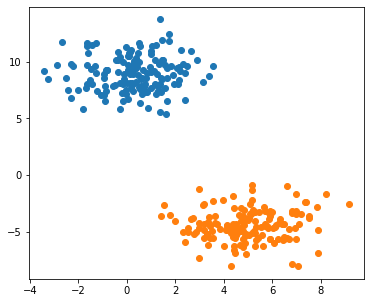

In [25]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=1.5, centers=2, random_state=23)

plot_data(X, y)

Применим к этой задаче алгоритм "решающий пень":

In [26]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

Accuracy = 1.0


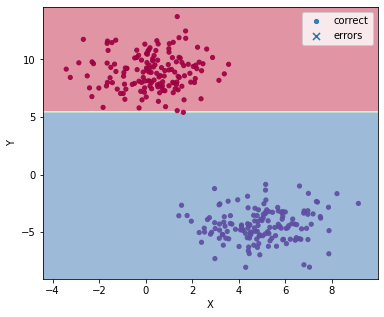

In [27]:
plot_decision_surface(some_tree, X, y)

Теперь рассмотрим более сложную задачу с плохо разделимыми классами:

In [30]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=2, centers=5, random_state=23)

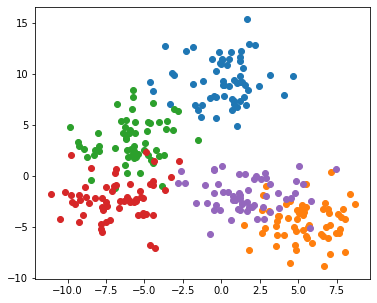

In [31]:
plot_data(X, y)

Посмотрим на результаты, которые получаются при разных значениях глубины:

Accuracy = 0.4


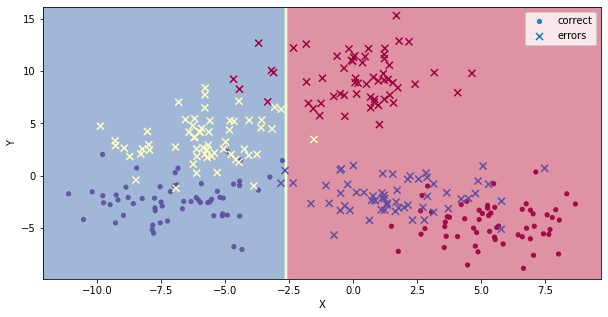

In [32]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.7466666666666667


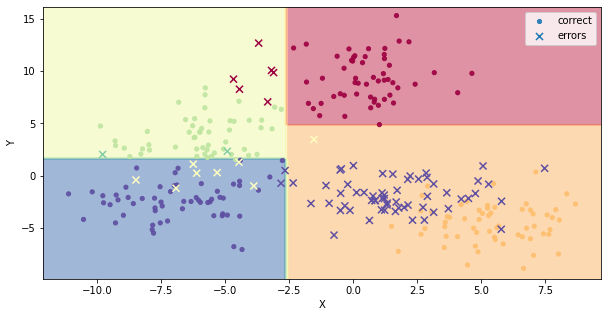

In [35]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.23


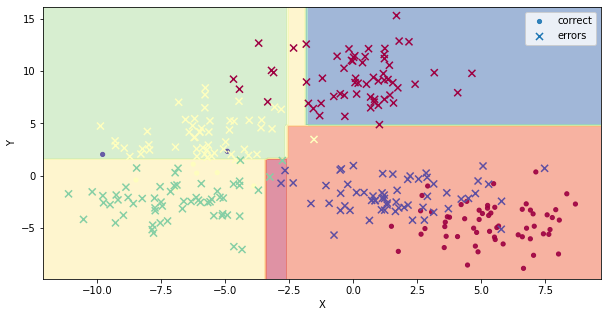

In [36]:
some_tree = ClassificationDecisionTree(max_depth=3, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.5666666666666667


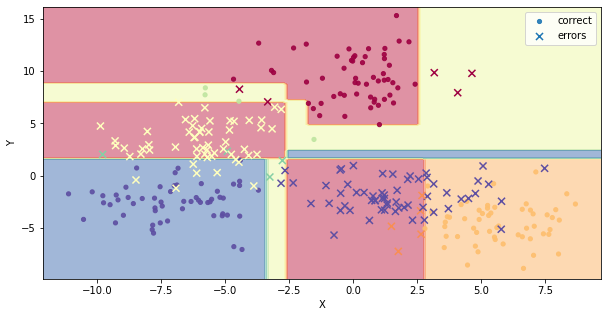

In [37]:
some_tree = ClassificationDecisionTree(max_depth=5, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.3433333333333333


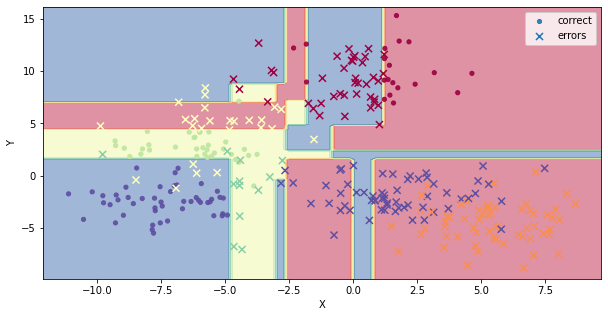

In [38]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Замечаем, что с глубины $max$_$depth=10$ дерево начинает сильно переобучаться (новые сплиты пытаются описать 1-2 объекта). Это можно поправить изменением параметра min_leaf_size.

Accuracy = 0.4066666666666667


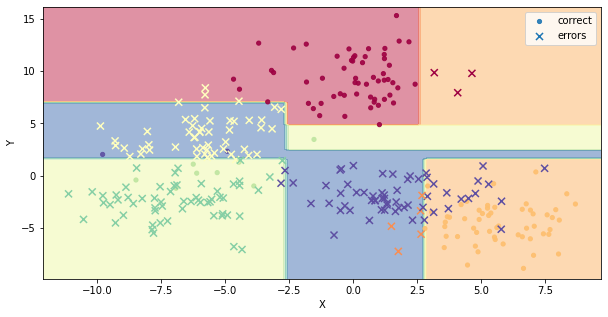

In [43]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=20)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))